In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import sys

In [2]:
class Dataset_Handler():
    
    def __init__(self, sequence, lidar=True, progress_bar=True, low_memory=True):
        
        self.lidar = lidar
        self.low_memory = low_memory
        
        self.seq_dir = '/home/logan_20/kitti_slam/dataset/sequences/{}/'.format(sequence)
        self.poses_dir = '/home/logan_20/kitti_slam/dataset/poses/{}.txt'.format(sequence)
        
        self.left_image_files = os.listdir(self.seq_dir + 'image_0')
        self.left_image_files.sort()
        self.right_image_files = os.listdir(self.seq_dir + 'image_1')
        self.right_image_files.sort()
        self.velodyne_files = os.listdir(self.seq_dir + 'velodyne')
        self.velodyne_files.sort()
        self.num_frames = len(self.left_image_files)
        self.lidar_path = self.seq_dir + 'velodyne/'
        
        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        self.gt = np.zeros((self.num_frames, 3, 4))
        
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape(3,4)
        
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3, 4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3, 4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3, 4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3, 4))
        self.Tr = np.array(calib.loc['Tr:']).reshape((3, 4))
        
        if low_memory:
            self.reset_frames()
            self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[0], 0)
            self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                               + self.right_image_files[0], 0)
            self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[1], 0)
            if self.lidar:
                self.first_pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[0],
                                                    dtype=np.float32, count=-1).reshape((-1, 4))
            self.imheight = self.first_image_left.shape[0]
            self.imwidth = self.first_image_left.shape[1]
        
        else:
            self.images_left = []
            self.images_right = []
            self.pointclouds = []
            if progress_bar:
                import progressbar
                bar = progressbar.ProgressBar(max_value=self.num_frames)
            for i, name_left in enumerate(self.left_image_files):
                name_right = self.right_image_files[i]
                self.images_left.append(cv2.imread(self.seq_dir + 'image_0/' + name_left, 0))
                self.images_right.append(cv2.imread(self.seq_dir + 'image_1/' + name_right, 0))
                if self.lidar:
                    pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[i], 
                                            dtype=np.float32, count=-1).reshape((-1, 4))
                    self.pointclouds.append(pointcloud)
                if progress_bar:
                    bar.update(i+1)
                self.imheight = self.images_left[0].shape[0]
                self.imwidth = self.images_right[0].shape[1]
                    
            
    def reset_frames(self):
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.right_image_files)
        if self.lidar:
            self.pointclouds = (np.fromfile(self.lidar_path + velodyne_file, 
                                            dtype=np.float32, count=-1).reshape((-1, 4))
                                for velodyne_file in self.velodyne_files)
        pass

In [3]:
# handler = Dataset_Handler('00',low_memory=False)
handler = Dataset_Handler('00')

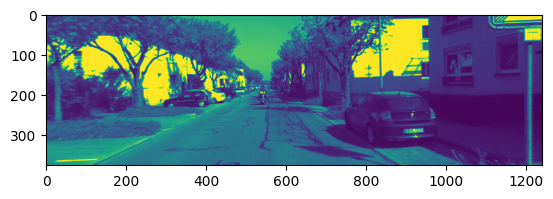

In [4]:
plt.imshow(next(handler.images_left))
# plt.imshow(handler.images_left[0])

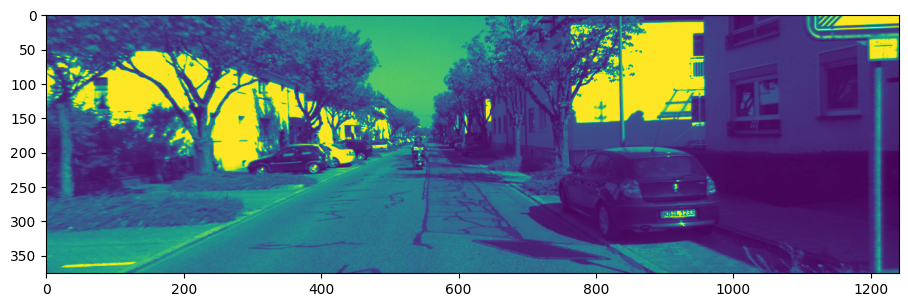

In [5]:
plt.figure(figsize=(11,7))
plt.imshow(handler.first_image_left);

In [6]:
handler.first_image_left.shape

(376, 1241)

In [7]:
def compute_left_disparity_map(img_left,img_right,matcher='bm',rgb=False,verbose=False):
    sad_window=6
    num_disparities=sad_window*16
    block_size=11
    matcher_name=matcher

    if matcher_name=='bm':
        matcher=cv2.StereoBM_create(numDisparities=num_disparities, blockSize=block_size)

    elif matcher_name=='sgbm':
        matcher=cv2.StereoSGBM_create(numDisparities=num_disparities, minDisparity=0, blockSize=block_size, P1=8*1*block_size ** 2, P2=32*1*block_size ** 2, 
                                      mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
        
    if rgb:
        img_left=cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right=cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    start=datetime.datetime.now()
    disp_left=matcher.compute(img_left,img_right).astype(np.float32)/16
    end=datetime.datetime.now()

    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}', end-start)

    return disp_left

Time to compute disparity map using StereoBM 0:00:00.010060


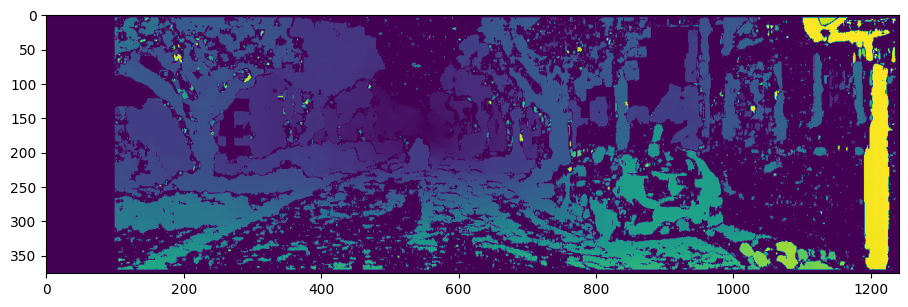

In [8]:
disp_bm=compute_left_disparity_map(handler.first_image_left, handler.first_image_right, matcher='bm', verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp_bm);

Time to compute disparity map using StereoSGBM 0:00:00.027848


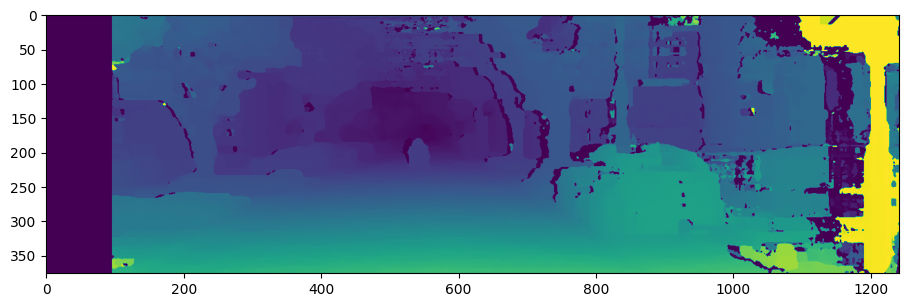

In [9]:
disp_sgbm=compute_left_disparity_map(handler.first_image_left, handler.first_image_right, matcher='sgbm', verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp_sgbm);

In [10]:
print(disp_bm[0,0])
print(disp_sgbm[0,0])

-1.0
-1.0


In [11]:
print("Disparity BM:")
print(disp_bm[disp_bm>-1.0].min())
print(disp_bm[disp_bm>0].min())
print(disp_bm[disp_bm>0].max())

Disparity BM:
0.0
0.5
95.0


In [12]:
print("Disparity SGBM:")
print(disp_sgbm[disp_sgbm>-1.0].min())
print(disp_sgbm[disp_sgbm>0].min())
print(disp_sgbm[disp_sgbm>0].max())

Disparity SGBM:
0.0
0.5625
95.0


In [13]:
handler.P0

array([[718.856 ,   0.    , 607.1928,   0.    ],
       [  0.    , 718.856 , 185.2157,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

In [14]:
k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(handler.P0)
print(k)
print(r)
print(t)

[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[0.]
 [0.]
 [0.]
 [1.]]


In [15]:
k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(handler.P1)
print(k)
print(r)
print((t/t[3]).round(4))

[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]]


In [16]:
def decompose_projection_matrix(p):
    k,r,t,_,_,_,_=cv2.decomposeProjectionMatrix(p)
    t=(t/t[3])[:3]
    return k,r,t

In [17]:
def calc_depth_map(disp_left,k_left,t_left,t_right,rectified=True):
    if rectified:
        b=t_right[0]-t_left[0]
    else:
        b=t_left[0]-t_right[0]
    f=k_left[0][0]

    disp_left[disp_left==0.0]=0.1
    disp_left[disp_left==-1.0]=0.1

    depth_map=np.ones(disp_left.shape)
    depth_map=f*b/disp_left    

    return depth_map

In [18]:
k_left,r_left,t_left=decompose_projection_matrix(handler.P0)
k_right,r_right,t_right=decompose_projection_matrix(handler.P1)

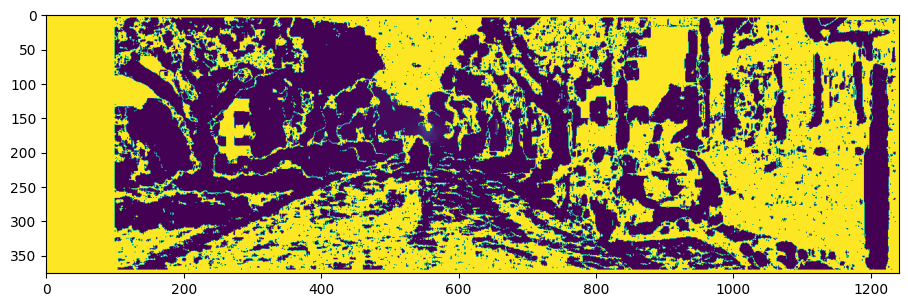

In [19]:
depth=calc_depth_map(disp_bm,k_left,t_left,t_right)
plt.figure(figsize=(11,7))
plt.imshow(depth);

In [20]:
depth[0,0]

3861.447942459941

In [21]:
depth.max()

3861.447942459941

(array([[  0.,   0.,   0., ...,   0.,   0., 376.],
        [  0.,   0.,   0., ...,   0.,   0., 376.],
        [  0.,   0.,   0., ...,   0.,   0., 376.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0., 376.],
        [  0.,   0.,   0., ...,   0.,   0., 376.],
        [  0.,   0.,   0., ...,   0.,   0., 376.]]),
 array([   4.06468211,  389.80300814,  775.54133418, 1161.27966021,
        1547.01798625, 1932.75631228, 2318.49463832, 2704.23296435,
        3089.97129039, 3475.70961642, 3861.44794246]),
 <a list of 1241 BarContainer objects>)

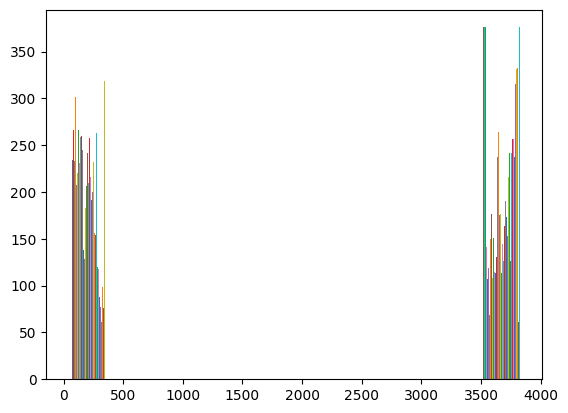

In [22]:
plt.hist(depth)

(array([216573.,    331.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 249712.]),
 array([   4.06468211,  389.80300814,  775.54133418, 1161.27966021,
        1547.01798625, 1932.75631228, 2318.49463832, 2704.23296435,
        3089.97129039, 3475.70961642, 3861.44794246]),
 <BarContainer object of 10 artists>)

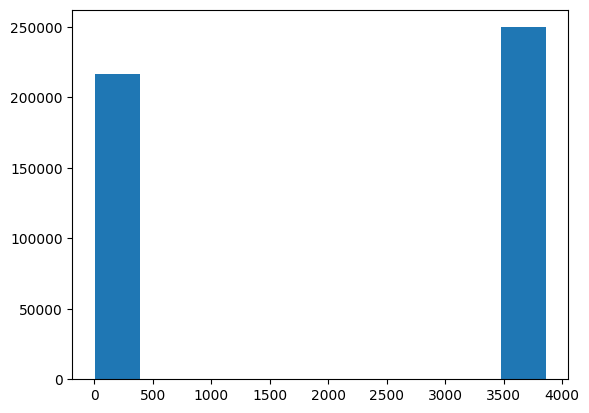

In [23]:
plt.hist(depth.flatten())

In [24]:
depth[depth<depth.max()].flatten().max()

772.2895999999998

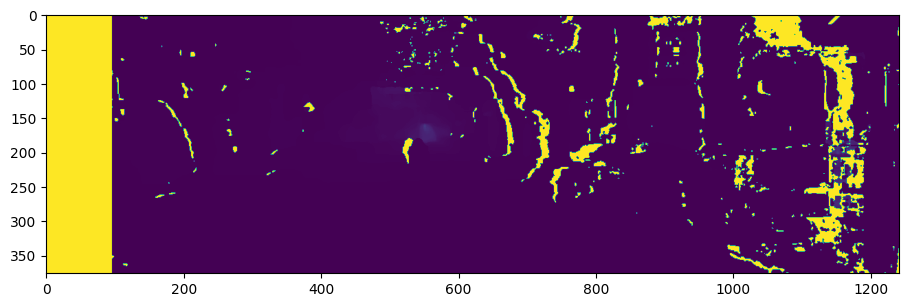

In [25]:
depth=calc_depth_map(disp_sgbm,k_left,t_left,t_right)
plt.figure(figsize=(11,7))
# depth[depth==depth.max()]=700
plt.imshow(depth);

In [26]:
depth[0,0]

3861.447942459941

In [27]:
depth.max()

3861.447942459941

In [28]:
for i,pixel in enumerate(depth[0]):
    if pixel<depth.max():
        print('First non-max value at index', i)
        break

First non-max value at index 96


(array([[  0.,   0.,   0., ...,   0.,   0., 376.],
        [  0.,   0.,   0., ...,   0.,   0., 376.],
        [  0.,   0.,   0., ...,   0.,   0., 376.],
        ...,
        [356.,   0.,   0., ...,   0.,   0.,  20.],
        [337.,   0.,   0., ...,   0.,   0.,  39.],
        [318.,   0.,   0., ...,   0.,   0.,  58.]]),
 array([   4.06468211,  389.80300814,  775.54133418, 1161.27966021,
        1547.01798625, 1932.75631228, 2318.49463832, 2704.23296435,
        3089.97129039, 3475.70961642, 3861.44794246]),
 <a list of 1241 BarContainer objects>)

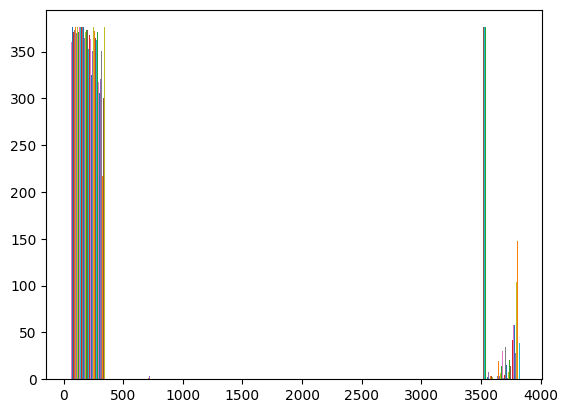

In [29]:
plt.hist(depth)

(array([406059.,    636.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  59921.]),
 array([   4.06468211,  389.80300814,  775.54133418, 1161.27966021,
        1547.01798625, 1932.75631228, 2318.49463832, 2704.23296435,
        3089.97129039, 3475.70961642, 3861.44794246]),
 <BarContainer object of 10 artists>)

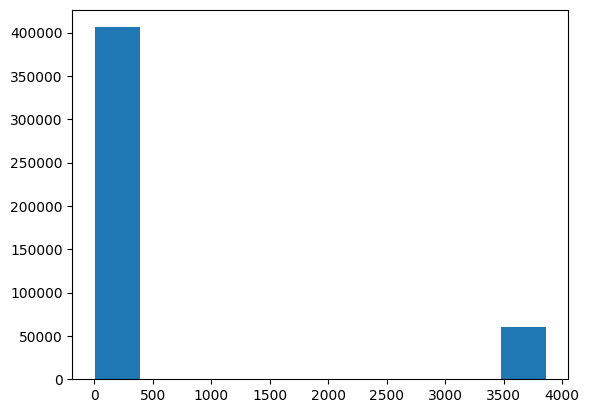

In [30]:
plt.hist(depth.flatten())

In [31]:
depth.shape

(376, 1241)

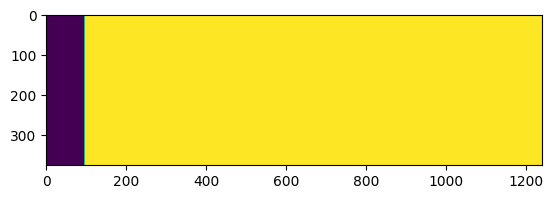

In [32]:
mask=np.zeros(depth.shape,dtype=np.uint8)
ymax=depth.shape[0]
xmax=depth.shape[1]
cv2.rectangle(mask,(96,0),(xmax,ymax),(255),thickness=-1)
plt.imshow(mask);

(array([ 36096.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 430520.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

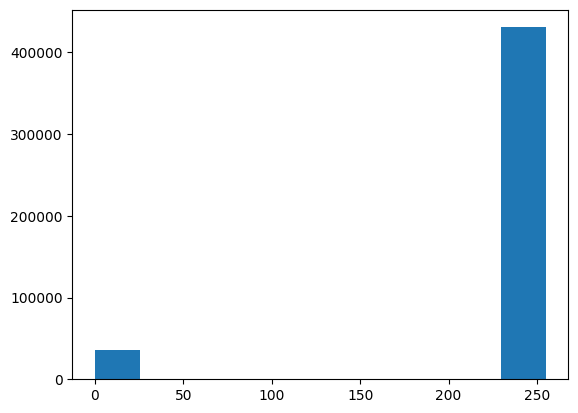

In [33]:
plt.hist(mask.flatten())

In [34]:
def stereo_2_depth(img_left,img_right,P0,P1,matcher='bm',rgb=False,verbose=True,rectified=False):
    disp_sgbm=compute_left_disparity_map(img_left,img_right,matcher=matcher,rgb=rgb,verbose=verbose)
    k_left,r_left,t_left=decompose_projection_matrix(P0)
    k_right,r_right,t_right=decompose_projection_matrix(P1)

    depth=calc_depth_map(disp_sgbm,k_left,t_left,t_right)
    return depth

Time to compute disparity map using StereoSGBM 0:00:00.026358


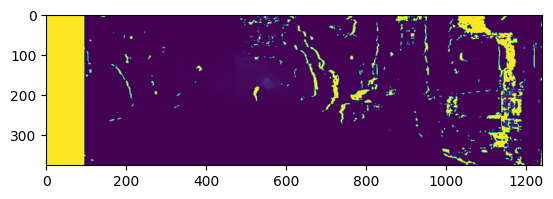

In [35]:
depth=stereo_2_depth(handler.first_image_left,handler.first_image_right,handler.P0,handler.P1,matcher='sgbm',rgb=False,verbose=True)
plt.imshow(depth);

In [36]:
pcloud=handler.first_pointcloud
print("Full pcloud shape: ",pcloud.shape)
trimmed_pcloud=pcloud[pcloud[:,0]>0]
print("Trimmed pcloud shape: ",trimmed_pcloud.shape)

Full pcloud shape:  (124668, 4)
Trimmed pcloud shape:  (63141, 4)


In [37]:
handler.Tr.round(4)

array([[ 4.000e-04, -1.000e+00, -8.100e-03, -1.200e-02],
       [-7.200e-03,  8.100e-03, -9.999e-01, -5.400e-02],
       [ 1.000e+00,  5.000e-04, -7.200e-03, -2.922e-01]])

In [38]:
handler.Tr.dot(trimmed_pcloud.T).shape

(3, 63141)

In [39]:
trimmed_pcloud.shape

(63141, 4)

In [40]:
hom_pcloud=np.hstack([trimmed_pcloud[:,:3],np.ones(trimmed_pcloud.shape[0]).reshape((-1,1))])
cam_xyz=handler.Tr.dot(trimmed_pcloud.T)
cam_xyz/=cam_xyz[2]
cam_xyz=np.vstack([cam_xyz,np.ones(cam_xyz.shape[1])])
projection=handler.P0.dot(cam_xyz)
projection[:,:5].T

array([[606.95511898, 152.8019536 ,   1.        ],
       [604.70040658, 152.93682998,   1.        ],
       [602.44536092, 152.95541569,   1.        ],
       [594.44678898, 153.74404704,   1.        ],
       [592.19822941, 153.75570653,   1.        ]])

In [41]:
pixel_coords=np.round(projection,0).T.astype('int')
pixel_coords[:5]

array([[607, 153,   1],
       [605, 153,   1],
       [602, 153,   1],
       [594, 154,   1],
       [592, 154,   1]])

In [42]:
# def pointcloud2image(pointcloud,imheight,imwidth,Tr,P0):

#     pointcloud=pointcloud[pointcloud[:,0]>0]
#     reflectance=pointcloud[:,3]
#     pointcloud = np.hstack([pointcloud[:, :3], np.ones(pointcloud.shape[0]).reshape((-1,1))])
    
#     cam_xyz=Tr.dot(pointcloud.T)
#     cam_xyz=cam_xyz[:,cam_xyz[2]>0]

#     depth=cam_xyz[2]
#     cam_xyz/=cam_xyz[2]
#     cam_xyz=np.vstack([cam_xyz,np.ones(cam_xyz.shape[1])])
#     projection=P0.dot(cam_xyz)
#     pixel_coordinates=np.round(projection.T,0).astype('int')

#     indices=np.where((pixel_coordinates[:,0]<imwidth)
#                      &(pixel_coordinates[:,0]>=0)
#                      &(pixel_coordinates[:,1]<imheight)
#                      &(pixel_coordinates[:,1]>=0))
    
#     pixel_coordinates=pixel_coordinates[indices]
#     depth=depth[indices]
#     reflectance=reflectance[indices]

#     render=np.zeros((imheight,imwidth))
#     for j, (u,v) in enumerate(pixel_coordinates):
#         if u>=imwidth or u<0:
#             continue
#         if v>=imheight or v<0:
#             continue
#         render[v,u]=depth[j]

#     return render

Time to compute disparity map using StereoSGBM 0:00:00.023715


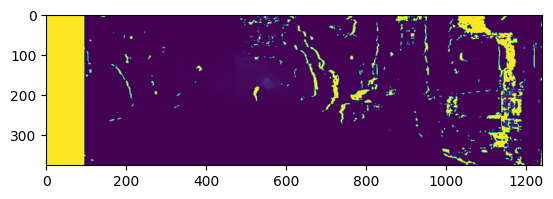

In [43]:
stereo_depth=stereo_2_depth(handler.first_image_left,handler.first_image_right,handler.P0,handler.P1,matcher='sgbm',rgb=False,verbose=True)
plt.imshow(stereo_depth);

In [75]:
def pointcloud2image(pointcloud, imheight, imwidth, Tr, P0):
    
    pointcloud = pointcloud[pointcloud[:, 0] > 0]
    reflectance = pointcloud[:, 3]
    # Make pointcloud homogeneous (X, Y, Z, 1)
    pointcloud = np.hstack([pointcloud[:, :3], np.ones(pointcloud.shape[0]).reshape((-1,1))])
    
    # Transform points into 3D coordinate frame of camera
    cam_xyz = Tr.dot(pointcloud.T)
    # Clip off negative z values
    cam_xyz = cam_xyz[:, cam_xyz[2] > 0]
    
    depth = cam_xyz[2].copy()
    
    cam_xyz /= cam_xyz[2]    
    cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
    projection = P0.dot(cam_xyz)
    pixel_coordinates = np.round(projection.T, 0)[:, :2].astype('int')
    
    indices = np.where((pixel_coordinates[:, 0] < imwidth)
                       & (pixel_coordinates[:, 0] >= 0)
                       & (pixel_coordinates[:, 1] < imheight)
                       & (pixel_coordinates[:, 1] >= 0))
    
    pixel_coordinates = pixel_coordinates[indices]
    depth = depth[indices]
    reflectance = reflectance[indices]
    
    render = np.zeros((imheight, imwidth))
    for j, (u, v) in enumerate(pixel_coordinates):
        if u >= imwidth or u < 0:
            continue
        if v >= imheight or v < 0:
            continue
        render[v, u] = depth[j]

    render[render==0.0]=3861.45
        
    return render

In [45]:
render=pointcloud2image(handler.first_pointcloud, handler.imheight, handler.imwidth, handler.Tr, handler.P0)

In [46]:
render.shape

(376, 1241)

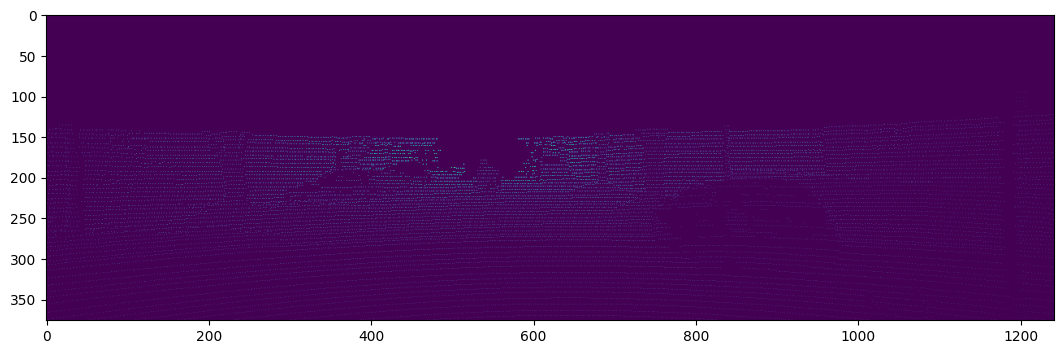

In [47]:
fig=plt.figure(figsize=(13,5))
plt.imshow(render);

In [48]:
handler.imheight

376

In [49]:
for i, d in enumerate(stereo_depth[200:,:].flatten()):
    if render[200:,:].flatten()[i]==0:
        continue
    print('Stereo Depth: ', d, ' Lidar Depth: ', render[200:,:].flatten()[i])
    if i > 1000:
        break

Stereo Depth:  24.040143190661475  Lidar Depth:  25.08251557273636
Stereo Depth:  36.99590898203592  Lidar Depth:  38.18529319193908
Stereo Depth:  37.67266341463414  Lidar Depth:  38.15661260397033
Stereo Depth:  37.67266341463414  Lidar Depth:  38.04491130916553
Stereo Depth:  38.13775802469135  Lidar Depth:  38.22929779114657
Stereo Depth:  38.37463850931676  Lidar Depth:  37.93287208133164
Stereo Depth:  38.61447999999999  Lidar Depth:  37.970212888663504
Stereo Depth:  38.61447999999999  Lidar Depth:  38.78230455441224
Stereo Depth:  39.10327088607594  Lidar Depth:  43.35304297366147
Stereo Depth:  52.80612649572648  Lidar Depth:  43.92954268130661
Stereo Depth:  56.681805504587146  Lidar Depth:  52.296451988896685
Stereo Depth:  57.20663703703703  Lidar Depth:  53.01673964440458
Stereo Depth:  57.20663703703703  Lidar Depth:  53.154098455093575
Stereo Depth:  57.741278504672884  Lidar Depth:  53.17143027237011
Stereo Depth:  57.741278504672884  Lidar Depth:  53.19275972156244
Ste

In [50]:
pcloud_frames=(pointcloud2image(next(handler.pointclouds), handler.imheight, handler.imwidth, handler.Tr, handler.P0)
                                for i in range(handler.num_frames))
#poses=(gt for gt in handler.gt)

In [51]:
handler.gt[10].round(4)

array([[ 9.9980e-01,  5.0000e-03, -2.0700e-02, -4.6870e-01],
       [-5.3000e-03,  9.9990e-01, -1.1500e-02, -2.8380e-01],
       [ 2.0600e-02,  1.1600e-02,  9.9970e-01,  8.5829e+00]])

In [52]:
handler.reset_frames()
poses=(gt for gt in handler.gt)

In [53]:
%matplotlib tk

In [54]:
xs=[]
ys=[]
zs=[]
compute_times=[]
fig=plt.figure()
ax=fig.add_subplot(projection='3d')
ax.view_init(elev=-20,azim=270)
ax.plot(handler.gt[:,0,3], handler.gt[:,1,3], handler.gt[:,2,3], c='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

stereo_l=handler.images_left
stereo_r=handler.images_right



for i in range(handler.num_frames//50):
    img_l=next(stereo_l)
    img_r=next(stereo_r)
    start=datetime.datetime.now()
    disp=compute_left_disparity_map(img_l,img_r,matcher='sgbm')
    disp/=disp.max()
    disp=1-disp
    disp=(disp*255).astype('uint8')
    disp=cv2.applyColorMap(disp, cv2.COLORMAP_RAINBOW)
    pcloud=(next(pcloud_frames))
    pcloud/=pcloud.max()
    pcloud=(pcloud*255).astype('uint8')
    
    gt=next(poses)
    xs.append(gt[0,3])
    ys.append(gt[1,3])
    zs.append(gt[2,3])
    plt.plot(xs,ys,zs,c='chartreuse')
    plt.pause(0.000000000000000001)
    cv2.imshow('Camera', img_l)
    cv2.imshow('Disparity',disp)
    cv2.imshow('Lidar',pcloud)
    cv2.waitKey(200)

    end=datetime.datetime.now()  
    compute_times.append(end-start)

plt.close()    
cv2.destroyAllWindows()

In [55]:
def extract_features(image, detector='isft', mask=None):
    if detector=='sift':
        det=cv2.SIFT_create()
        # det=cv2.xfeatures2d.SIFT_create
    elif detector=='orb':
        det=cv2.ORB_create()

    kp, des=det.detectAndCompute(image, mask)

    return kp, des


In [56]:
def match_features(des1, des2, matching='BF', detector='sift', sort=False, k=2):
    if matching=='BF':
        if detector=='sift':
            matcher=cv2.BFMatcher_create(cv2.NORM_L2,crossCheck=False)
        elif detector=='orb':
            matcher=cv2.BFMatcher_create(cv2.NORM_HAMMING2,crossCheck=False)
        
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE=1
        index_params=dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params=dict(checks=50)
        matcher=cv2.FlannBasedMatcher(index_params,search_params)

    matches=matcher.knnMatch(des1, des2, k=k)

    if sort:
        matches=sorted(matches, key=lambda x: x[0].distance)
    
    return matches


In [57]:
def visualize_matches(image1, kp1, image2, kp2, match):
    image_matches=cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16,6), dpi=100)
    plt.imshow(image_matches)

In [58]:
def filter_matches_distance(matches, dist_threshold=0.5):
    filtered_match=[]
    for m, n in matches:
        if m.distance<=dist_threshold * n.distance:
            filtered_match.append(m)

    return filtered_match

In [59]:
%matplotlib inline

Number of matches before filtering:  2931
Number of matches after filtering:  445
Time to match and filter:  0:00:00.163350


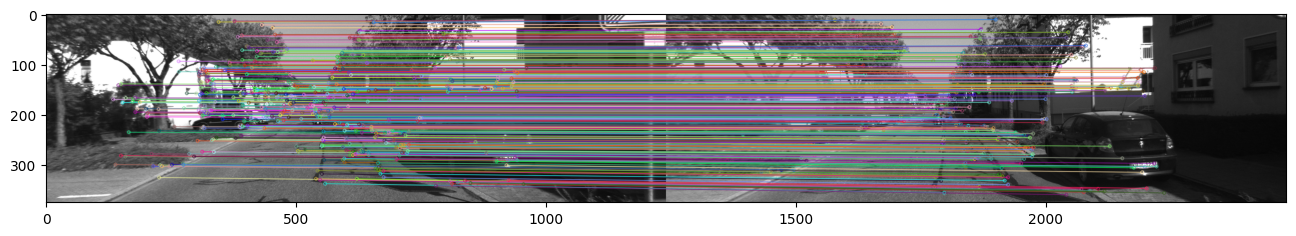

In [60]:
import datetime

image_left=handler.first_image_left
image_right=handler.first_image_right
image_plus1=handler.second_image_left

start=datetime.datetime.now()
kp0, des0=extract_features(image_left, 'sift', mask)
kp1, des1=extract_features(image_plus1, 'sift', mask)

matches=match_features(des0, des1, matching='BF', detector='sift', sort=False)
# matches=[match[0] for match in matches]
print("Number of matches before filtering: ", len(matches))
matches=filter_matches_distance(matches, 0.3)
print("Number of matches after filtering: ", len(matches))
end=datetime.datetime.now()
print("Time to match and filter: ", end-start)

visualize_matches(image_left, kp0, image_plus1, kp1, matches)

Number of matches before filtering:  500
Number of matches after filtering:  19
Time to match and filter:  0:00:00.021730


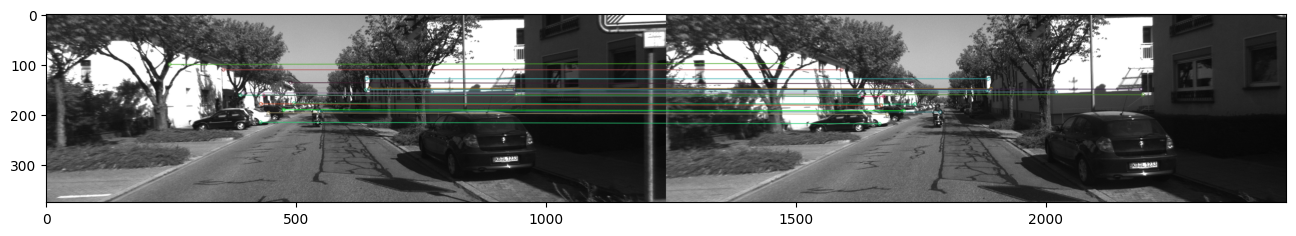

In [61]:
image_left=handler.first_image_left
image_right=handler.first_image_right
image_plus1=handler.second_image_left

start=datetime.datetime.now()
kp0, des0=extract_features(image_left, 'orb', mask)
kp1, des1=extract_features(image_plus1, 'orb', mask)

matches=match_features(des0, des1, matching='BF', detector='orb', sort=False)
# matches=[match[0] for match in matches]
print("Number of matches before filtering: ", len(matches))
matches=filter_matches_distance(matches, 0.3)
print("Number of matches after filtering: ", len(matches))
end=datetime.datetime.now()
print("Time to match and filter: ", end-start)

visualize_matches(image_left, kp0, image_plus1, kp1, matches)

In [62]:
# kp1[0].pt

In [63]:
def estimate_motion(matches, kp1, kp2, k, depth1, max_depth=3000):
    rmat=np.eye(3)
    tvec=np.zeros((3,1))

    image1_points=np.float32([kp1[m.queryIdx].pt for m in matches])
    image2_points=np.float32([kp2[m.trainIdx].pt for m in matches])

    cx=k[0,2]
    cy=k[1,2]
    fx=k[0,0]
    fy=k[1,1]

    object_points=np.zeros((0,3))
    delete=[]

    for i,(u,v) in enumerate(image1_points):
        z=depth1[int(round(v)), int(round(u))]
        if z>max_depth:
            delete.append(i)
            continue

        x=z*(u-cx)/fx
        y=z*(v-cy)/fy
        object_points=np.vstack([object_points, np.array([x,y,z])])
        # object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])


    image1_points=np.delete(image1_points, delete, 0)
    image2_points=np.delete(image2_points, delete, 0)

    __, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
    rmat=cv2.Rodrigues(rvec)[0]

    return rmat, tvec, image1_points, image2_points

In [64]:
k,r,t,_,_,_,_=cv2.decomposeProjectionMatrix(handler.P0)
k

array([[718.856 ,   0.    , 607.1928],
       [  0.    , 718.856 , 185.2157],
       [  0.    ,   0.    ,   1.    ]])

In [65]:
rmat,tvec,image1_points,image2_points=estimate_motion(matches, kp0, kp1, k, depth)
print("Rotation Matrix: ")
print(rmat.round(4))
print("Translation Vector: ")
print(tvec.round(4))

Rotation Matrix: 
[[ 1.      0.002   0.0034]
 [-0.002   1.      0.0029]
 [-0.0034 -0.0029  1.    ]]
Translation Vector: 
[[-0.0086]
 [-0.0196]
 [-0.7005]]


In [66]:
transformation_matrix=np.hstack([rmat,tvec])
print(transformation_matrix.round(4))

[[ 1.      0.002   0.0034 -0.0086]
 [-0.002   1.      0.0029 -0.0196]
 [-0.0034 -0.0029  1.     -0.7005]]


In [67]:
print(handler.gt[1].round(4))

[[ 1.000e+00  5.000e-04 -2.100e-03 -4.690e-02]
 [-5.000e-04  1.000e+00 -1.200e-03 -2.840e-02]
 [ 2.100e-03  1.200e-03  1.000e+00  8.587e-01]]


In [68]:
hom_trans_mat=np.eye(4)
hom_trans_mat

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [69]:
hom_trans_mat[:3,:3]=rmat
hom_trans_mat[:3,3]=tvec.T
hom_trans_mat.round(4)

array([[ 1.    ,  0.002 ,  0.0034, -0.0086],
       [-0.002 ,  1.    ,  0.0029, -0.0196],
       [-0.0034, -0.0029,  1.    , -0.7005],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [70]:
(np.linalg.inv(hom_trans_mat))

array([[ 0.99999204, -0.00204789, -0.0034245 ,  0.0061153 ],
       [ 0.0020381 ,  0.99999384, -0.00285805,  0.01766217],
       [ 0.00343033,  0.00285104,  0.99999005,  0.70055576],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [71]:
print(handler.gt[1].round(4))

[[ 1.000e+00  5.000e-04 -2.100e-03 -4.690e-02]
 [-5.000e-04  1.000e+00 -1.200e-03 -2.840e-02]
 [ 2.100e-03  1.200e-03  1.000e+00  8.587e-01]]


In [81]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None,
                    stereo_matcher='sgbm', mask=None, subset=None, plot=False):
    # Determine if handler has lidar data
    lidar = handler.lidar
    
    # Report methods being used to user
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector),
                                                                  matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
    if lidar:
        print('Improving stereo depth estimation with lidar data')
    if subset is not None:
        num_frames = subset
    else:
        num_frames = handler.num_frames
        
    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=-20, azim=270)
        xs = handler.gt[:, 0, 3]
        ys = handler.gt[:, 1, 3]
        zs = handler.gt[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k')
        
    # Establish a homogeneous transformation matrix. First pose is identity
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth
    
    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
    
    if handler.low_memory:
        handler.reset_frames()
        image_plus1 = next(handler.images_left)
        
    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        start = datetime.datetime.now()
        
        if handler.low_memory:
            image_left = image_plus1
            image_plus1 = next(handler.images_left)
            image_right = next(handler.images_right)
        else:
            image_left = handler.images_left[i]
            image_plus1 = handler.images_left[i+1]
            image_right = handler.images_right[i]
            
        depth = stereo_2_depth(image_left,
                               image_right,
                               P0=handler.P0,
                               P1=handler.P1,
                               matcher=stereo_matcher
                              )
        
        if lidar:
            if handler.low_memory:
                pointcloud = next(handler.pointclouds)
            else:
                pointcloud = handler.pointclouds[i]
            
            lidar_depth = pointcloud2image(pointcloud,
                                           imheight=imheight,
                                           imwidth=imwidth,
                                           Tr=handler.Tr,
                                           P0=handler.P0
                                          )
            indices = np.where(lidar_depth > 0)
            depth[indices] = lidar_depth[indices]
            
        # Get keypoints and descriptors for left camera image of two sequential frames
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)
        
        # Get matches between features detected in two subsequent frames
        matches_unfilt = match_features(des0, 
                                        des1,
                                        matching=matching,
                                        detector=detector
                                       )
        #print('Number of features before filtering: ', len(matches_unfilt))
        
        # Filter matches if a distance threshold is provided by user
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
        
        #print('Number of features after filtering: ', len(matches))
        #print('Length of kp0:', len(kp0))
        #print('Length of kp1:', len(kp1))
            
        # Estimate motion between sequential images of the left camera
        rmat, tvec, img1_points, img2_points = estimate_motion(matches,
                                                               kp0,
                                                               kp1,
                                                               k_left,
                                                               depth
                                                              )
        
        # Create a blank homogeneous transformation matrix
        Tmat = np.eye(4)
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
        
        trajectory[i+1, :, :] = T_tot[:3, :]
        
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)
            
    if plot:
        plt.close()
        
    return trajectory

In [82]:
%matplotlib tk

In [83]:
plt.close()

In [86]:
trajectory_test=visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=0.3, stereo_matcher='sgbm', mask=mask, subset=None, plot=True)

Generating disparities with StereoSGBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.3*distance
Improving stereo depth estimation with lidar data
Time to compute disparity map using StereoSGBM 0:00:00.016453
Time to compute frame 1: 0:00:00.206563
Time to compute disparity map using StereoSGBM 0:00:00.027498
Time to compute frame 2: 0:00:00.231760
Time to compute disparity map using StereoSGBM 0:00:00.025249
Time to compute frame 3: 0:00:00.238715
Time to compute disparity map using StereoSGBM 0:00:00.023444
Time to compute frame 4: 0:00:00.224599
Time to compute disparity map using StereoSGBM 0:00:00.024817
Time to compute frame 5: 0:00:00.231057
Time to compute disparity map using StereoSGBM 0:00:00.024060
Time to compute frame 6: 0:00:00.228490
Time to compute disparity map using StereoSGBM 0:00:00.023988
Time to compute frame 7: 0:00:00.229818
Time to compute disparity map using StereoSGBM 0:00:00.024426
Time to compute frame 8: 0:00:

KeyboardInterrupt: 